# Semantic Segmentation using U-Net

U-Net, proposed by Ronneberger et al. in 2015, a convolutional neural network (CNN) architecture, has gained significant prominence, particularly in biomedical image segmentation. Renowned for its ability to capture intricate details while preserving spatial information, U-Net has found widespread use in various image segmentation applications. This repository delves into the Semantic Segmentation task using U-Net, aiming to achieve high accuracy measured by the mean Intersection over Union (mIoU) metric.

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import os
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "/content/drive/MyDrive/Colab Notebooks/UNet"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Labels.txt', '.DS_Store', 'Problem2.py', 'Data', '__pycache__', 'UNet.ipynb']


In [27]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

In [28]:
from Problem2 import *
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


Data Visualization

In [30]:
batch_size = 2
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, "Data")

trainset = ImageSegmentation(DATA_PATH, "Train", transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, collate_fn=trainset.collate_fn)

valset = ImageSegmentation(DATA_PATH, "Val", transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, collate_fn=valset.collate_fn)

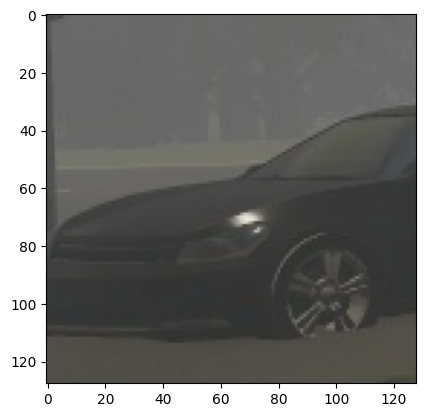

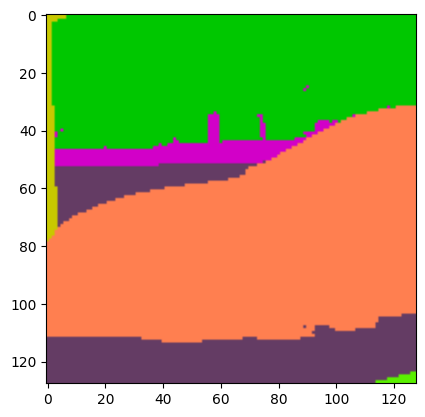

In [31]:
def imshow(img):
    img = img / 2 + 0.5     # un-normalize
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_labels(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
demo_image = images[0, :, :, :]
imshow(demo_image)
# show labels
demo_label = labels[0, :, :, :]
imshow_labels(demo_label)

In [32]:
label_file = open(os.path.join(DATA_PATH, "Labels.txt"), "r")
class_dict = {}

i = 0
label_file.readline()
for line in label_file:
    text = line.split("\n")[0]
    tokens = text.split(" ")
    rgb = np.array([int(tokens[1]), int(tokens[2]), int(tokens[3])])
    class_dict[i] = rgb
    i += 1

# Convert colored image to labels
def to_labels(label_img, color_to_label):
    B, H, W, C = label_img.shape
    labels = torch.zeros((B, H, W, 1), device=label_img.device)
    for i, rgb in color_to_label.items():
        mask = (label_img[:, :, :, 0] == rgb[0]) & (label_img[:, :, :, 1] == rgb[1]) & (label_img[:, :, :, 2] == rgb[2])
        labels[mask] = i
    return labels

Training

In [33]:
def train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion):
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      # Train
      net.train()
      total_loss = 0
      best_iou = 0
      i = 0
      loop = tqdm(trainloader)
      for data in loop:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = net(inputs)
          B, C, H, W = outputs.shape
          outputs = outputs.permute(0, 2, 3, 1)
          outputs = outputs.reshape(-1, C)
          labels = to_labels(labels, class_dict)
          labels = labels.long().view(-1)


          # backward + optimize
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          loop.set_description("Training")
          total_loss += loss.detach().item()
          i += 1
          loop.set_postfix(loss=total_loss / i)

      # Validate
      net.eval()
      loop = tqdm(val_loader)
      loop.set_description("Validation")
      with torch.no_grad():
        all_targets = []
        all_preds = []
        for data in loop:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Forward pass
            outputs = net(inputs)
            B, C, H, W = outputs.shape
            outputs = outputs.permute(0, 2, 3, 1)
            outputs = outputs.reshape(-1, C)
            labels = to_labels(labels, class_dict)
            labels = labels.long().view(-1)

            # Targets and predictions for iou
            _, predicted = torch.max(outputs, 1)
            all_targets.append(labels)
            all_preds.append(predicted)
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        iou, miou = IoU(all_targets, all_preds, 15)
        if miou > best_iou:
          best_iou = miou
        PATH = os.path.join(DATA_PATH, 'YourNet.pth')
        torch.save(net.state_dict(), PATH)

        # print statistics
        print(f'epochs: {epoch + 1} mIoU Val: {100 * miou.item():.3f}')
  print('Finished Training')
  return net

In [34]:
num_classes = 15
net = UNetStudent(num_classes).to(device)
# Loss function and optimizer
lr = 0.06
num_epochs = 55
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

# Training the first time will take a while. After the first pass through
# the data, training will speed up.
net = train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion)

Validation: 100%|██████████| 125/125 [00:06<00:00, 20.20it/s]


epochs: 1 mIoU Val: 45.167


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.53it/s]


epochs: 2 mIoU Val: 39.681


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.24it/s]


epochs: 3 mIoU Val: 37.118


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.60it/s]


epochs: 4 mIoU Val: 40.877


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.40it/s]


epochs: 5 mIoU Val: 44.593


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.54it/s]


epochs: 6 mIoU Val: 40.781


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.23it/s]


epochs: 7 mIoU Val: 49.441


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.56it/s]


epochs: 8 mIoU Val: 40.661


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.53it/s]


epochs: 9 mIoU Val: 41.890


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.53it/s]


epochs: 10 mIoU Val: 43.780


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.37it/s]


epochs: 11 mIoU Val: 40.028


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.41it/s]


epochs: 12 mIoU Val: 42.104


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.03it/s]


epochs: 13 mIoU Val: 37.190


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.00it/s]


epochs: 14 mIoU Val: 40.970


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.67it/s]


epochs: 15 mIoU Val: 41.495


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.07it/s]


epochs: 16 mIoU Val: 44.257


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.08it/s]


epochs: 17 mIoU Val: 42.249


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.51it/s]


epochs: 18 mIoU Val: 47.099


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.36it/s]


epochs: 19 mIoU Val: 46.086


Validation: 100%|██████████| 125/125 [00:06<00:00, 17.86it/s]


epochs: 20 mIoU Val: 38.966


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.67it/s]


epochs: 21 mIoU Val: 49.238


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.68it/s]


epochs: 22 mIoU Val: 43.786


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.58it/s]


epochs: 23 mIoU Val: 44.882


Validation: 100%|██████████| 125/125 [00:07<00:00, 16.88it/s]


epochs: 24 mIoU Val: 45.993


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.05it/s]


epochs: 25 mIoU Val: 44.665


Validation: 100%|██████████| 125/125 [00:07<00:00, 16.91it/s]


epochs: 26 mIoU Val: 42.971


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.05it/s]


epochs: 27 mIoU Val: 48.651


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.06it/s]


epochs: 28 mIoU Val: 42.631


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.13it/s]


epochs: 29 mIoU Val: 43.014


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.35it/s]


epochs: 30 mIoU Val: 46.561


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.67it/s]


epochs: 31 mIoU Val: 44.177


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.81it/s]


epochs: 32 mIoU Val: 46.694


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.05it/s]


epochs: 33 mIoU Val: 42.883


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.36it/s]


epochs: 34 mIoU Val: 43.418


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.65it/s]


epochs: 35 mIoU Val: 50.128


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.82it/s]


epochs: 36 mIoU Val: 41.848


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.90it/s]


epochs: 37 mIoU Val: 43.936


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.06it/s]


epochs: 38 mIoU Val: 46.027


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.31it/s]


epochs: 39 mIoU Val: 48.253


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.50it/s]


epochs: 40 mIoU Val: 43.965


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.19it/s]


epochs: 41 mIoU Val: 45.157


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.33it/s]


epochs: 42 mIoU Val: 41.601


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.42it/s]


epochs: 43 mIoU Val: 47.868


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.02it/s]


epochs: 44 mIoU Val: 44.135


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.31it/s]


epochs: 45 mIoU Val: 47.180


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.10it/s]


epochs: 46 mIoU Val: 51.494


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.64it/s]


epochs: 47 mIoU Val: 48.285


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.53it/s]


epochs: 48 mIoU Val: 50.647


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.74it/s]


epochs: 49 mIoU Val: 41.299


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.78it/s]


epochs: 50 mIoU Val: 46.788


Validation: 100%|██████████| 125/125 [00:06<00:00, 20.17it/s]


epochs: 51 mIoU Val: 49.269


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.69it/s]


epochs: 52 mIoU Val: 39.842


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.39it/s]


epochs: 53 mIoU Val: 39.699


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.27it/s]


epochs: 54 mIoU Val: 44.097


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.14it/s]


epochs: 55 mIoU Val: 41.597
Finished Training


Save Weights


In [35]:
# Save Weights
PATH = os.path.join(DATA_PATH, 'YourNet.pth')
torch.save(net.state_dict(), PATH)

Visualize predictions

In [36]:
net = UNetStudent(num_classes).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [37]:
# Convert colored image to labels
def label_to_image(label_img, color_to_label):
    B, H, W = label_img.shape
    colored_img = torch.zeros((B, H, W, 3), device=label_img.device, dtype=torch.uint8)
    for i, rgb in color_to_label.items():
        mask = label_img == i
        colored_img[mask, :] = torch.tensor(rgb, device=label_img.device, dtype=torch.uint8)
    return colored_img

Ground Truth


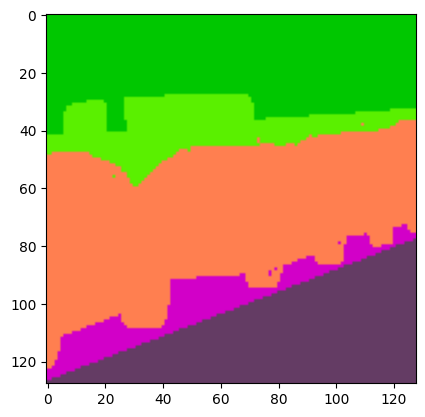

Prediction


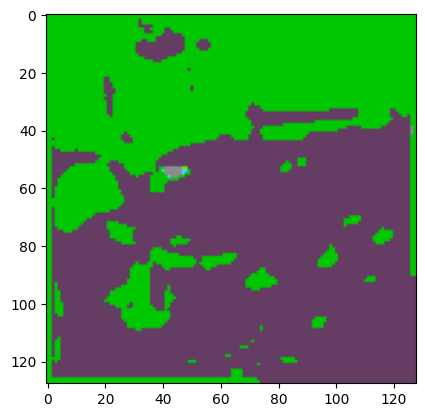

In [38]:
with torch.no_grad():
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Make predictions
    # Forward pass
    outputs = net(images)
    B, C, H, W = outputs.shape
    outputs = outputs.permute(0, 2, 3, 1)
    # Targets and predictions for iou
    _, predicted = torch.max(outputs, 3)
    predicted_img = label_to_image(predicted, class_dict)
    # show labels
    print("Ground Truth")
    demo_label = labels[0, :, :, :]
    imshow_labels(demo_label)
    # Show predictions
    print("Prediction")
    demo_pred = predicted_img[0, :, :, :]
    imshow_labels(demo_pred)

Customization


In [59]:
num_classes = 15
net = UNetStudent(num_classes).to(device)

# Hyper-parameters
lr = 0.000555
num_epochs = 80
batch_size = 10

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

In [60]:
trainset = ImageSegmentation(DATA_PATH, "Train", transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, collate_fn=trainset.collate_fn)

valset = ImageSegmentation(DATA_PATH, "Val", transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, collate_fn=valset.collate_fn)

In [ ]:
net = train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion)
#torch.save(net.state_dict(), PATH)

Validation: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


epochs: 1 mIoU Val: 44.165


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


epochs: 2 mIoU Val: 46.334


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


epochs: 3 mIoU Val: 51.010


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


epochs: 4 mIoU Val: 52.542


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


epochs: 5 mIoU Val: 54.849


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epochs: 6 mIoU Val: 51.611


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.44it/s]


epochs: 7 mIoU Val: 54.674


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


epochs: 8 mIoU Val: 53.023


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


epochs: 9 mIoU Val: 57.010


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epochs: 10 mIoU Val: 59.639


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


epochs: 11 mIoU Val: 50.390


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


epochs: 12 mIoU Val: 55.323


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]


epochs: 13 mIoU Val: 55.113


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


epochs: 14 mIoU Val: 55.774


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


epochs: 15 mIoU Val: 55.447


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epochs: 16 mIoU Val: 50.866


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


epochs: 17 mIoU Val: 55.678


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epochs: 18 mIoU Val: 57.029


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


epochs: 19 mIoU Val: 53.197


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.60it/s]


epochs: 20 mIoU Val: 55.750


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


epochs: 21 mIoU Val: 54.364


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


epochs: 22 mIoU Val: 54.323


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


epochs: 23 mIoU Val: 57.871


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


epochs: 24 mIoU Val: 52.851


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


epochs: 25 mIoU Val: 55.332


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


epochs: 26 mIoU Val: 53.056


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.41it/s]


epochs: 27 mIoU Val: 55.422


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


epochs: 28 mIoU Val: 55.440


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.56it/s]


epochs: 29 mIoU Val: 53.833


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.65it/s]


epochs: 30 mIoU Val: 55.152


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


epochs: 31 mIoU Val: 51.142


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.58it/s]


epochs: 32 mIoU Val: 55.302


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


epochs: 33 mIoU Val: 55.096


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


epochs: 34 mIoU Val: 54.417


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.36it/s]


epochs: 35 mIoU Val: 53.986


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.35it/s]


epochs: 36 mIoU Val: 58.939


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epochs: 37 mIoU Val: 53.213


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


epochs: 38 mIoU Val: 54.692


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


epochs: 39 mIoU Val: 53.297


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


epochs: 40 mIoU Val: 52.523


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


epochs: 41 mIoU Val: 54.827


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


epochs: 42 mIoU Val: 53.133


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


epochs: 43 mIoU Val: 54.921


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


epochs: 44 mIoU Val: 55.131


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.45it/s]


epochs: 45 mIoU Val: 53.601


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


epochs: 46 mIoU Val: 57.556


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


epochs: 47 mIoU Val: 53.861


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


epochs: 48 mIoU Val: 54.542


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.70it/s]


epochs: 49 mIoU Val: 55.736


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


epochs: 50 mIoU Val: 53.728


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.55it/s]


epochs: 51 mIoU Val: 54.316


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


epochs: 52 mIoU Val: 54.287


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


epochs: 53 mIoU Val: 54.325


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.48it/s]


epochs: 54 mIoU Val: 55.247


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


epochs: 55 mIoU Val: 55.650


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.53it/s]


epochs: 56 mIoU Val: 54.787


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.59it/s]


epochs: 57 mIoU Val: 54.751


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.69it/s]


epochs: 58 mIoU Val: 55.679


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


epochs: 59 mIoU Val: 53.882


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


epochs: 60 mIoU Val: 58.433


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


epochs: 61 mIoU Val: 54.348


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.46it/s]


epochs: 62 mIoU Val: 56.625


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


epochs: 63 mIoU Val: 54.133


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epochs: 64 mIoU Val: 56.538


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.49it/s]


epochs: 65 mIoU Val: 54.799


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.54it/s]


epochs: 66 mIoU Val: 54.346


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.62it/s]


epochs: 67 mIoU Val: 55.410


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.73it/s]


epochs: 68 mIoU Val: 53.899


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.63it/s]


epochs: 69 mIoU Val: 54.078


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


epochs: 70 mIoU Val: 55.296


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.50it/s]


epochs: 71 mIoU Val: 55.502


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


epochs: 72 mIoU Val: 53.121


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


epochs: 73 mIoU Val: 54.482


Validation: 100%|██████████| 25/25 [00:10<00:00,  2.47it/s]


epochs: 74 mIoU Val: 55.261


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.52it/s]


epochs: 75 mIoU Val: 54.468


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


epochs: 76 mIoU Val: 56.509


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.67it/s]


epochs: 77 mIoU Val: 55.603


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.68it/s]


epochs: 78 mIoU Val: 56.608


Validation: 100%|██████████| 25/25 [00:09<00:00,  2.57it/s]


epochs: 79 mIoU Val: 53.961


Validation:  68%|██████▊   | 17/25 [00:06<00:03,  2.41it/s]

In [55]:
net = UNetStudent(num_classes).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [57]:
testset = ImageSegmentation(DATA_PATH, "Test", transform=transform_test(), device=device)

In [58]:
# Test
i = 0
net.eval()
save_dir = os.path.join(DATA_PATH, "Test", "Problem2_Predictions")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

i = 0
with torch.no_grad():
  for inputs, __ in iter(testset):
    # We are only evaluating every tenth image due to memory constraints on
    # Auto-grader
    if i % 10 == 0:
      C, H, W = inputs.shape
      outputs = net(inputs.view(1, C, H, W).to(device))
      B, C, H, W = outputs.shape
      outputs = outputs.permute(0, 2, 3, 1)
      predictions = outputs.argmax(dim=3).view(H, W)
      predictions_np = predictions.detach().cpu().numpy().astype(np.uint8)
      save_path = os.path.join(save_dir, str(i).zfill(6) + ".label")
      predictions_np.tofile(save_path)
    i += 1